![Mars Panorama](mars.jpg)

# RedRank

#### A Bayesian Terraforming Mars player rating system using Microsoft TrueSkill

#### Kevin Beam

In [1]:
from io import StringIO
import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn')

The game results are entered in a [Google Sheet](https://docs.google.com/spreadsheets/d/1sOV2dhdXgPbWmacQRWN1hEVUBWzfpy5c6T5W-qowGoY/edit#gid=0) and are pulled in dynamically when this notebook is run.

In [2]:
r = requests.get('https://docs.google.com/spreadsheet/ccc?key=1sOV2dhdXgPbWmacQRWN1hEVUBWzfpy5c6T5W-qowGoY&output=csv&gid=0')
csv_data = r.content.decode('utf-8')
games = pd.read_csv(StringIO(csv_data), index_col=0, parse_dates=['Date'])
games.fillna('-')

,Allis,Benjamin,Kevin,Matt,Steve,Todd
Date,,,,,,
2019-01-19,-,62,48,78,60,64
2019-01-20,145,-,-,-,-,115


---

# TrueSkill

#### Use Microsoft TrueSkill to rate the players

---

In [3]:
import math
from functools import partial
from scipy.stats import norm
import seaborn as sns; sns.set()
from trueskill import global_env, rate, setup, Rating, BETA
setup(backend='scipy')

trueskill.TrueSkill(mu=25.000, sigma=8.333, beta=4.167, tau=0.083, draw_probability=10.0%, backend='scipy')

In [4]:
ratings = {n: Rating() for n in games.columns}

In [5]:
def update_ratings(ratings, game):
    game = game.dropna()
    rating_groups = [(ratings[n],) for n in game.index]
    ranks = game.rank(ascending=False).values.astype(int)
    new_ratings = rate(rating_groups, ranks)
    for n, nr in zip(game.index, new_ratings):
        ratings[n] = nr[0]
        
games.apply(partial(update_ratings, ratings), axis='columns')

Date
2019-01-19    None
2019-01-20    None
dtype: object

## TrueSkill ratings after all games

In [6]:
ratings

{'Allis': trueskill.Rating(mu=31.449, sigma=6.618),
 'Benjamin': trueskill.Rating(mu=25.000, sigma=5.420),
 'Kevin': trueskill.Rating(mu=15.637, sigma=6.136),
 'Matt': trueskill.Rating(mu=34.363, sigma=6.136),
 'Steve': trueskill.Rating(mu=20.942, sigma=5.536),
 'Todd': trueskill.Rating(mu=26.212, sigma=5.065)}

## Conservative estimate of player strength -- there is a 99% chance your rating is above this level

In [7]:
for n, r in ratings.items():
    print('{}: {:.4}'.format(n, r.mu - 3*r.sigma))

Allis: 11.6
Benjamin: 8.74
Kevin: -2.772
Matt: 15.95
Steve: 4.334
Todd: 11.02


## Player rating estimate curves
### Location of the peak indicates mean player strength estimate, width of curve is the estimate uncertainty

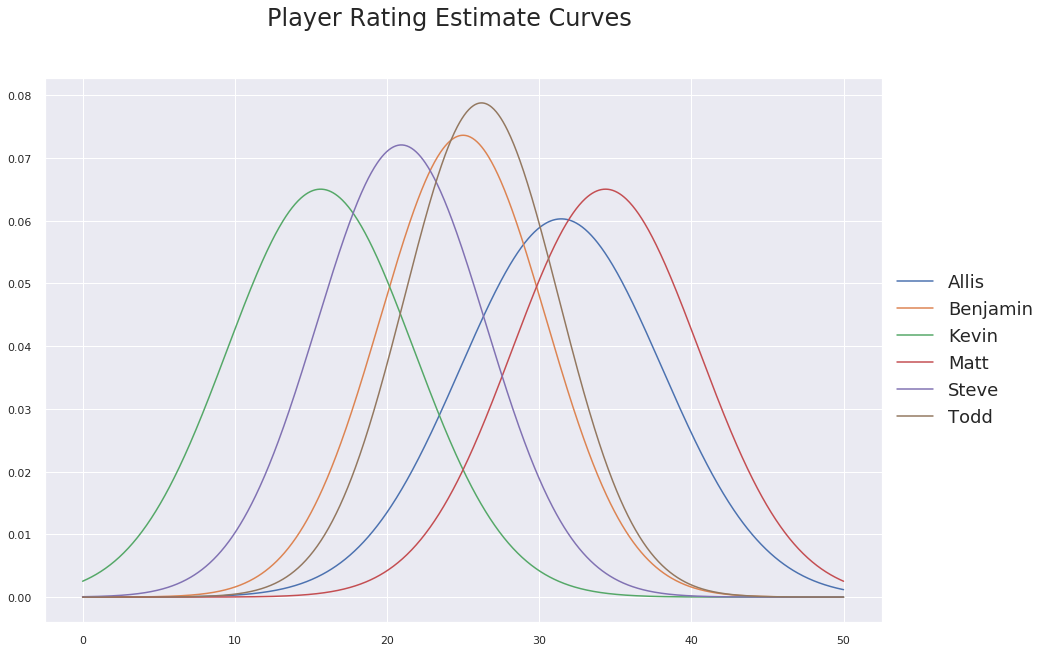

In [8]:
f = plt.figure(figsize=(15,10))
f.suptitle('Player Rating Estimate Curves', fontsize=24)
x = np.linspace(0,50,1000)
for n, r in ratings.items():
    plt.plot(x, norm.pdf(x, loc=r.mu, scale=r.sigma), label=n)
plt.legend(loc='center right', bbox_to_anchor=(1.2, 0.5), fontsize=18)

## Pairwise expected match results based on player rating, which includes rating uncertainty

In [9]:
def win_prob(p1, p2):
    delta_mu = p1.mu - p2.mu
    sum_sigma = p1.sigma ** 2 + p2.sigma ** 2
    return global_env().cdf(delta_mu / math.sqrt(2*BETA*BETA + sum_sigma))
        
wp = {n: [100*win_prob(ratings[o], ratings[n]) for o in games.columns] 
      for n in games.columns}
wp_df = pd.DataFrame(wp, index=games.columns)
wp_df

,Allis,Benjamin,Kevin,Matt,Steve,Todd
Allis,50.000000,73.266370,92.882048,39.345419,84.272097,69.607272
Benjamin,26.733630,50.000000,82.335286,17.664714,66.164185,44.910274
Kevin,7.117952,17.664714,50.000000,3.710946,30.061397,14.274130
Matt,60.654581,82.335286,96.289054,50.000000,90.697243,79.482102
Steve,15.727903,33.835815,69.938603,9.302757,50.000000,29.033000
Todd,30.392728,55.089726,85.725870,20.517898,70.967000,50.000000


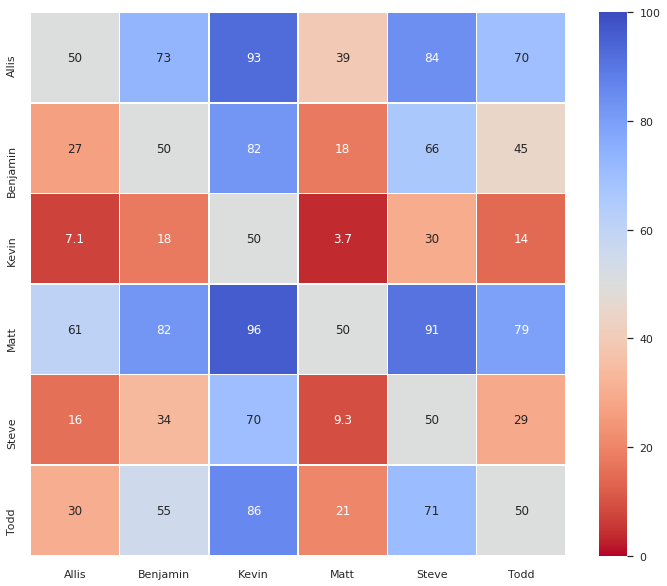

In [10]:
plt.subplots(figsize=(12,10))
sns.heatmap(wp_df, vmin=0, vmax=100, annot=True, linewidths=0.5, cmap='coolwarm_r')